# Single-image food volume estimation
Using a  monocular depth estimation network and a segmentation network, we will estimate the volume of the food displayed in the input image.

In [1]:
%cd C:\Source\food_volume_estimation

C:\Source\food_volume_estimation


In [2]:
import sys
import json
from keras.models import Model, model_from_json
from food_volume_estimation.volume_estimator import VolumeEstimator
from food_volume_estimation.depth_estimation.custom_modules import *
from food_volume_estimation.food_segmentation.food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud

# Paths to model archiecture/weights
depth_model_architecture = 'models/fine_tune_food_videos/monovideo_fine_tune_food_videos.json'
depth_model_weights = 'models/fine_tune_food_videos/monovideo_fine_tune_food_videos.h5'
segmentation_model_weights = 'models/segmentation/mask_rcnn_food_segmentation.h5'

Using TensorFlow backend.
C:\Users\flap9\miniconda3\envs\food-tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\flap9\miniconda3\envs\food-tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\flap9\miniconda3\envs\food-tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\flap9\miniconda3\envs\food

In [3]:
import tensorflow as tf
print(tf.__version__)
print("TensorFlow GPU:",tf.test.is_gpu_available())

1.14.0
TensorFlow GPU: False


In [4]:
# Create estimator object and intialize
estimator = VolumeEstimator(arg_init=False)
with open(depth_model_architecture, 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False) #False
estimator.monovideo.load_weights(depth_model_weights)
estimator.model_input_shape = estimator.monovideo.inputs[0].shape.as_list()[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
print('[*] Loaded depth estimation model.')

# Depth model configuration
MIN_DEPTH = 0.01
MAX_DEPTH = 10
estimator.min_disp = 1 / MAX_DEPTH
estimator.max_disp = 1 / MIN_DEPTH
estimator.gt_depth_scale = 0.35 # Ground truth expected median depth

# Create segmentator object
estimator.segmentator = FoodSegmentator(segmentation_model_weights)

# Set plate adjustment relaxation parameter
estimator.relax_param = 0.01

[*] VolumeEstimator not initialized.








Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use `tf.cast` instead.

[*] Loaded depth estimation model.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

[*] Loading segmentation model weights models/segmentation/mask_rcnn_food_segmentation.h5


[*] Creating intrinsics matrix from given FOV: 70
[*] Ellipse parameters: (116.49103546142578, 67.40454864501953, 90.0, 61.81818181818181, 0.2193849618428625)
[*] Found 3 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.2499547671594378, 0.04264826432666251, -0.4524638376021571, -0.890762370788221]
[*] Estimated volume: 0.05838863856547237 L


C:\Source\food_volume_estimation\food_volume_estimation\point_cloud_utils.py:163: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows + cols + str(r + 1))


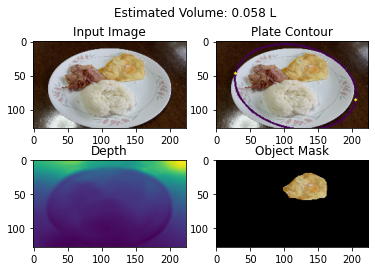

[*] Estimated plane parameters (w0,w1,w2,w3): [0.25144324340475904, -0.03671685307906241, -0.35602206399902075, -0.9337559438342803]
[*] Estimated volume: 0.05194131847590567 L


C:\Source\food_volume_estimation\food_volume_estimation\point_cloud_utils.py:163: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows + cols + str(r + 1))


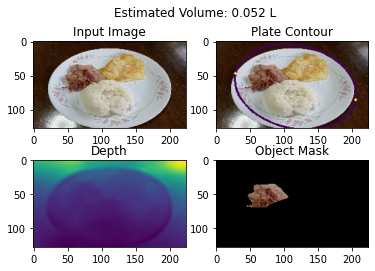

[*] Estimated plane parameters (w0,w1,w2,w3): [0.24404455423623495, 0.017522126936285097, -0.4237478971874466, -0.9056106750126379]
[*] Estimated volume: 0.10664054397075964 L


C:\Source\food_volume_estimation\food_volume_estimation\point_cloud_utils.py:163: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows + cols + str(r + 1))


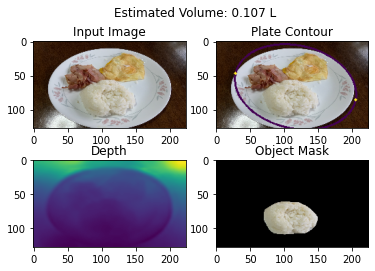

In [7]:
%matplotlib inline

# Estimate volumes in input image
input_image = 'images/IMG_0972.JPG'
plate_diameter = 0.35 # Set as 0 to ignore plate detection and scaling
outputs_list = estimator.estimate_volume(input_image, fov=70, plate_diameter_prior=plate_diameter, 
                                         plot_results=True)

In [6]:
%matplotlib widget
# Plot results for all detected food objects
for outputs in outputs_list:
    (estimated_volume, object_points_df, non_object_points_df, plane_points_df, object_points_transformed_df, 
        plane_points_transformed_df, simplices) = outputs
    fig = plt.gcf()
    fig.set_size_inches(6.5, 5.3)
    
    # Flip x and z coordinates to match point cloud with plotting axes
    object_points_df.values[:,0] *= -1
    object_points_df.values[:,2] *= -1
    non_object_points_df.values[:,0] *= -1
    non_object_points_df.values[:,2] *= -1
    plane_points_df.values[:,0] *= -1
    plane_points_df.values[:,2] *= -1
    
    # Create point cloud objects and plot
    object_pc = PyntCloud(object_points_df)
    non_object_pc = PyntCloud(non_object_points_df)
    plane_pc = PyntCloud(plane_points_df)
    scene = object_pc.plot(initial_point_size=0.005, return_scene=True)
    non_object_pc.plot(initial_point_size=0.005, scene=scene)
    plane_pc.plot(initial_point_size=0.001, use_as_color='z', cmap='cool', scene=scene)
    
    # Create transformed point clouds and plot
    plane_transformed_pc = PyntCloud(plane_points_transformed_df)
    object_transformed_pc = PyntCloud(object_points_transformed_df)
    scene = object_transformed_pc.plot(initial_point_size=0.005, return_scene=True)
    plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

    # Plot x-y plane triangulation of food object
    volume_points = object_points_transformed_df.values[object_points_transformed_df.values[:,2] > 0]
    plt.figure()
    plt.triplot(volume_points[:,0], volume_points[:,1], simplices)
    plt.plot(volume_points[:,0], volume_points[:,1], 'o', markersize=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Food X-Y triangulation')

    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …